In [8]:
import os

In [9]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # For implicit ALS

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import pandas as pd
import numpy as np

from implicit.als import AlternatingLeastSquares

from rectools.metrics import Precision, Recall, MAP, calc_metrics
from rectools.models import PopularModel, RandomModel, ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel


import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
import typing as tp
from tqdm import tqdm

from lightfm import LightFM

from implicit.bpr import BayesianPersonalizedRanking

from implicit.lmf import LogisticMatrixFactorization

In [12]:
%cd ../..

/home/kirill/PycharmProjects/pythonProject


In [13]:
DATA_PATH = Path("data/kion_train")


# LOAD DATA

In [14]:
%%time
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

CPU times: user 2.18 s, sys: 258 ms, total: 2.44 s
Wall time: 2.72 s


### Users

In [15]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


### Items

In [17]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [18]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


### Interactions

In [19]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [20]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 208.9+ MB


# Small EDA

### Users

In [21]:
print(f"Всего уникальных пользователей: {users[Columns.User].nunique():,}")

Всего уникальных пользователей: 840,197


In [22]:
def plot_normalized_barh_chart(
    dataframe: pd.DataFrame,
    column_name: str,
    title: str,
    figsize: tp.Tuple[int, int] = (12, 7),
    annotate_chart: bool = True,
    xlabel: tp.Optional[str] = None,
    ylabel: tp.Optional[str] = None,
) -> plt.Axes.axes:
    ax = (
        dataframe[column_name]
        .value_counts(dropna=False, normalize=True)
        .sort_index()
        .plot(
            kind='barh',
            grid=True,
            title=title,
            figsize=figsize,
            xlabel=xlabel,
            ylabel=ylabel,
        )
    )

    if annotate_chart:
        for bars in ax.containers:
            ax.bar_label(bars, labels=[f'{x:.1%}' for x in bars.datavalues])

In [23]:
users['sex'] = users['sex'].map({'Ж': 1, 'М': 0})

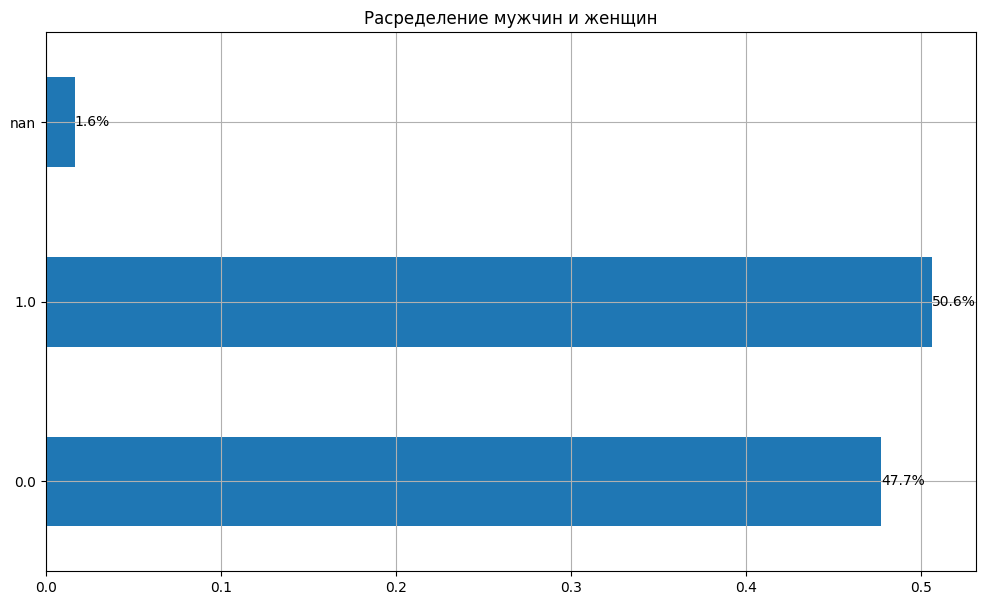

In [24]:
plot_normalized_barh_chart(users, 'sex', 'Расределение мужчин и женщин')

In [25]:
age_category = pd.CategoricalDtype(
    categories=[
        'age_18_24',
        'age_25_34',
        'age_35_44',
        'age_45_54',
        'age_55_64',
        'age_65_inf',
    ],
    ordered=True,
)

In [26]:
users['age'] = users['age'].astype(age_category)

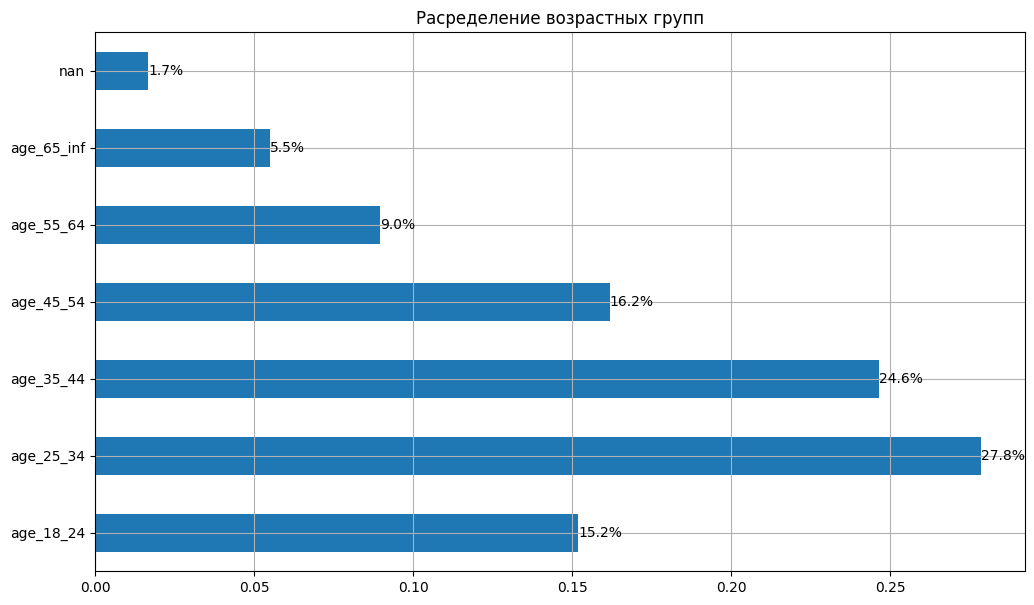

In [27]:
plot_normalized_barh_chart(users, 'age', 'Расределение возрастных групп')

In [28]:
income_category = pd.CategoricalDtype(
    categories=[
        'income_0_20',
        'income_20_40',
        'income_40_60',
        'income_60_90',
        'income_90_150',
        'income_150_inf',
    ],
    ordered=True,
)

In [29]:
users['income'] = users['income'].astype(income_category)

In [30]:
users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,0.0,1
1,962099,age_18_24,income_20_40,0.0,0
2,1047345,age_45_54,income_40_60,1.0,0
3,721985,age_45_54,income_20_40,1.0,0
4,704055,age_35_44,income_60_90,1.0,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,1.0,0
840193,983617,age_18_24,income_20_40,1.0,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,1.0,0


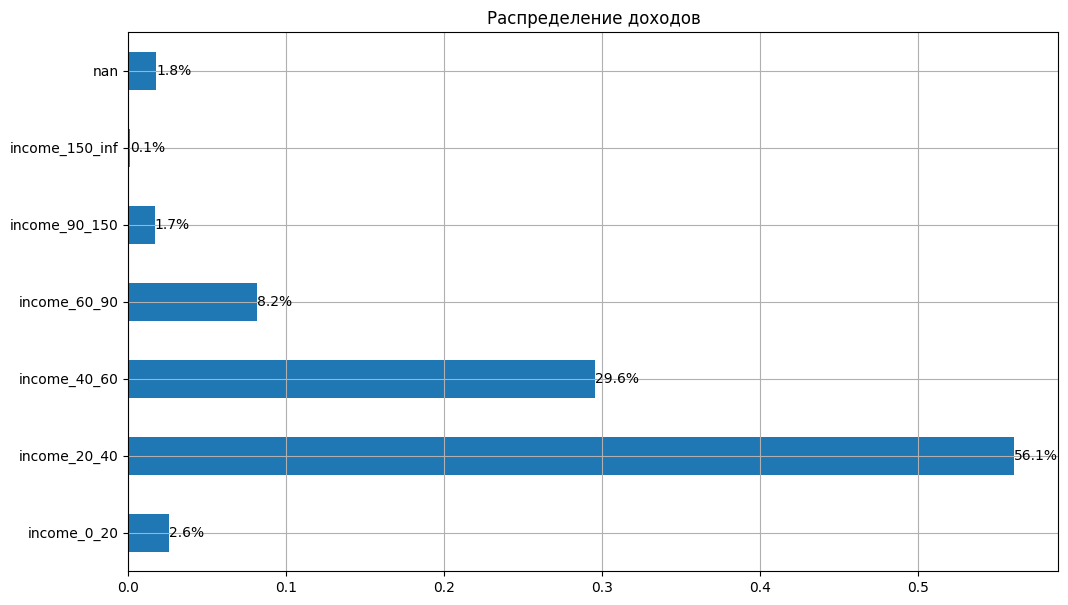

In [31]:
plot_normalized_barh_chart(users, 'income', 'Распределение доходов')

### Items

In [32]:
print(f"Всего уникальных айтемов: {items[Columns.Item].nunique():,}")

Всего уникальных айтемов: 15,963


In [33]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [34]:
YEAR_FROM = 1990
STEP_SIZE = 5
bins = [year for year in range(YEAR_FROM, int(items['release_year'].max()) + STEP_SIZE, STEP_SIZE)]

In [35]:
bins = [int(items['release_year'].min())] + bins

In [36]:
items['year_bin'] = pd.cut(items['release_year'],
                           bins=bins, include_lowest=True)

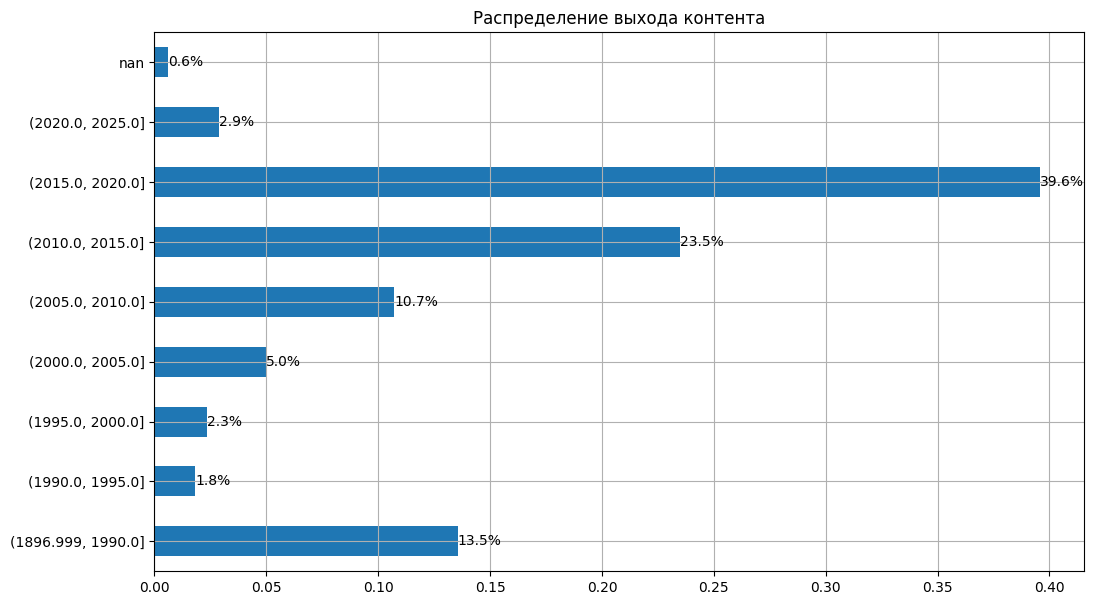

In [37]:
plot_normalized_barh_chart(items, 'year_bin', 'Распределение выхода контента')

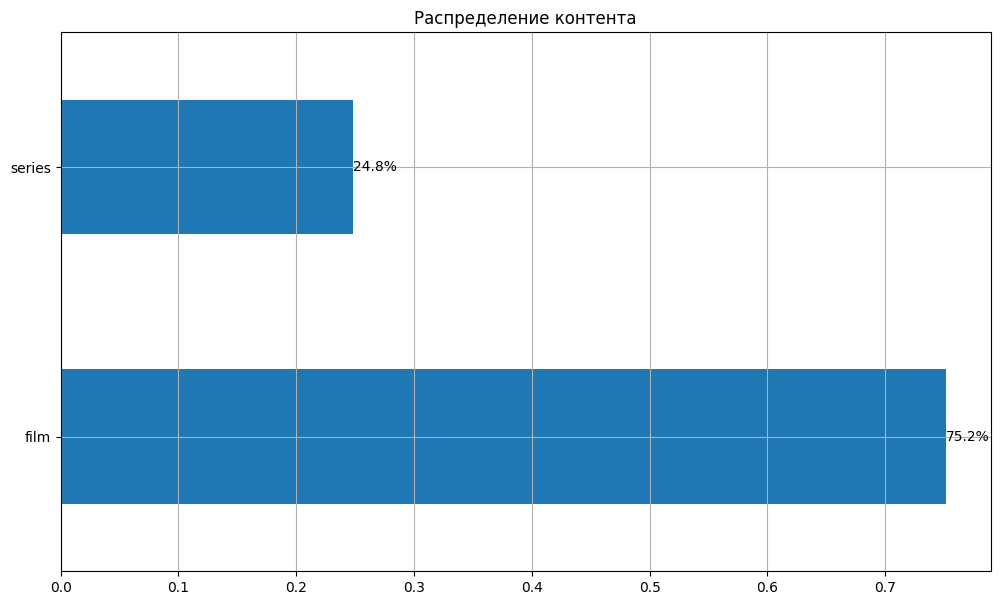

In [38]:
plot_normalized_barh_chart(items, 'content_type', 'Распределение контента')

### Interactions

In [39]:
print('Кол-во уникальных пользователей и айтемов в интеракциях')
interactions[Columns.UserItem].nunique()

Кол-во уникальных пользователей и айтемов в интеракциях


user_id    962179
item_id     15706
dtype: int64

In [40]:
Columns.Datetime = 'last_watch_dt'

In [41]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [42]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [43]:
interactions.drop(interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True)

In [44]:
interactions[Columns.Datetime].str.len().value_counts()

10    5476251
Name: last_watch_dt, dtype: int64

In [45]:
interactions[Columns.Datetime].min(), interactions[Columns.Datetime].max()

('2021-03-13', '2021-08-22')

# Train/Test split

In [46]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [47]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [48]:
interactions.dtypes

user_id                   int64
item_id                   int64
last_watch_dt    datetime64[ns]
total_dur                 int64
watched_pct             float64
dtype: object

In [49]:
max_date = interactions[Columns.Datetime].max()

Видим, что есть какие-то выбросы, пока на них не обращаем внимание, посмотрим, что получается

In [50]:
interactions['total_dur'].describe(percentiles=[.01,.1,.5,.9,.99]).round(2)

count     5476251.00
mean         8295.49
std         48567.99
min             1.00
1%              3.00
10%            42.00
50%          2898.00
90%         15112.00
99%         90083.00
max      80411672.00
Name: total_dur, dtype: float64

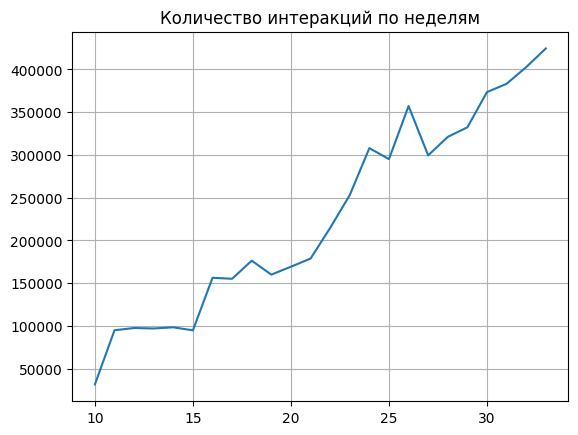

In [51]:
(
    interactions[Columns.Datetime].dt.isocalendar().week
    .value_counts(sort=False)
    .sort_index()
    .plot(grid=True, title='Количество интеракций по неделям')
);

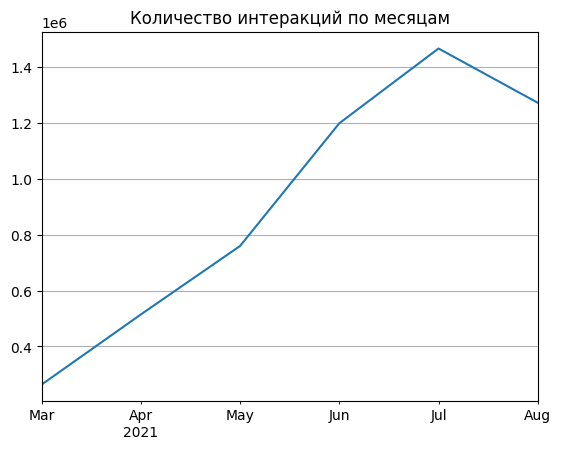

In [52]:
(
    interactions[Columns.Datetime].dt.to_period('M')
    .value_counts(sort=False)
    .sort_index()
    .plot(grid=True, title='Количество интеракций по месяцам')
);

In [53]:
(interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)).sum()

490982

In [54]:
interactions['watched_pct'].describe().round()

count    5475423.0
mean          46.0
std           42.0
min            0.0
25%            4.0
50%           32.0
75%          100.0
max          100.0
Name: watched_pct, dtype: float64

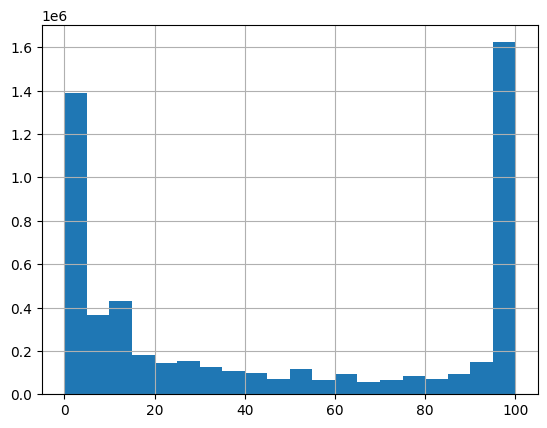

In [55]:
interactions['watched_pct'].hist(bins=20);

In [56]:
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 15, 3, 1)

In [57]:
interactions[Columns.Weight].value_counts(normalize=True)

3    0.591957
1    0.408043
Name: weight, dtype: float64

In [58]:
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 6)
test: (490982, 6)


In [59]:
train.drop(train.query("total_dur < 300").index, inplace=True)

In [60]:
# отфильтруем холодных пользователей из теста
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [61]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

# MODELS

In [62]:
K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 16
N_FACTORS = (32, 64, 128, 160)
ITERATIONS = (15, 20)

In [63]:
metrics_name = {
    'Precision': Precision,
    'Recall': Recall,
    'MAP': MAP,
}

metrics = {}
for metric_name, metric in metrics_name.items():
    for k in range(1, 11):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [64]:
dataset = Dataset.construct(
        interactions_df=train
    )

In [141]:
list_metrics_combined = {}

for components in [15,16,17]:
    for losses in ['logistic', 'bpr', 'warp']:
        for rho in [0.91,0.92,0.93]:
            for lr in [0.05,0.005]:
                epsilon = 3

                lightfm = LightFMWrapperModel(
                        model = LightFM(
                            no_components = components,
                            learning_schedule = 'adadelta',
                            loss = losses,
                            rho = rho,
                            epsilon = epsilon,
                            learning_rate = lr,
                            random_state = RANDOM_STATE
                        )
                    )

                lightfm.fit(dataset)

                recs = lightfm.recommend(
                    users=test[Columns.User].unique(),
                    dataset=dataset,
                    k=K_RECOS,
                    filter_viewed=True,
                )

                metric_values = calc_metrics(metrics, recs, test, train)

                list_metrics_combined[f"{components}_{losses}_{rho}_{lr}"] = metric_values
                print(f"MAP@10({components}_{losses}_{rho}_{lr}) = {metric_values['MAP@10']}")

                

MAP@10(15_logistic_0.91_0.05) = 0.07405564143311494
MAP@10(15_logistic_0.91_0.005) = 0.07405564143311494
MAP@10(15_logistic_0.92_0.05) = 0.07405564143311494
MAP@10(15_logistic_0.92_0.005) = 0.07405564143311494
MAP@10(15_logistic_0.93_0.05) = 0.07405564143311494
MAP@10(15_logistic_0.93_0.005) = 0.07405564143311494
MAP@10(15_bpr_0.91_0.05) = 0.0014111577538332139
MAP@10(15_bpr_0.91_0.005) = 0.0014111577538332139
MAP@10(15_bpr_0.92_0.05) = 0.0015701517529424346
MAP@10(15_bpr_0.92_0.005) = 0.0015701517529424346
MAP@10(15_bpr_0.93_0.05) = 0.0025517490013550123
MAP@10(15_bpr_0.93_0.005) = 0.0025517490013550123
MAP@10(15_warp_0.91_0.05) = 0.05592339219925232
MAP@10(15_warp_0.91_0.005) = 0.05592339219925232
MAP@10(15_warp_0.92_0.05) = 0.058181852835044894
MAP@10(15_warp_0.92_0.005) = 0.058181852835044894
MAP@10(15_warp_0.93_0.05) = 0.05976275661426571
MAP@10(15_warp_0.93_0.005) = 0.05976275661426571
MAP@10(16_logistic_0.91_0.05) = 0.0740546489556007
MAP@10(16_logistic_0.91_0.005) = 0.074054648

In [146]:
for k,v in list_metrics_combined.items():
    print(k,v['MAP@10'])

15_logistic_0.91_0.05 0.07405564143311494
15_logistic_0.91_0.005 0.07405564143311494
15_logistic_0.92_0.05 0.07405564143311494
15_logistic_0.92_0.005 0.07405564143311494
15_logistic_0.93_0.05 0.07405564143311494
15_logistic_0.93_0.005 0.07405564143311494
15_bpr_0.91_0.05 0.0014111577538332139
15_bpr_0.91_0.005 0.0014111577538332139
15_bpr_0.92_0.05 0.0015701517529424346
15_bpr_0.92_0.005 0.0015701517529424346
15_bpr_0.93_0.05 0.0025517490013550123
15_bpr_0.93_0.005 0.0025517490013550123
15_warp_0.91_0.05 0.05592339219925232
15_warp_0.91_0.005 0.05592339219925232
15_warp_0.92_0.05 0.058181852835044894
15_warp_0.92_0.005 0.058181852835044894
15_warp_0.93_0.05 0.05976275661426571
15_warp_0.93_0.005 0.05976275661426571
16_logistic_0.91_0.05 0.0740546489556007
16_logistic_0.91_0.005 0.0740546489556007
16_logistic_0.92_0.05 0.0740546489556007
16_logistic_0.92_0.005 0.0740546489556007
16_logistic_0.93_0.05 0.0740546489556007
16_logistic_0.93_0.005 0.0740546489556007
16_bpr_0.91_0.05 0.0080022

#### По итогу получаем, что моделью с самыми лучшими гиперпарамметрами является "17_logistic_0.93_0.05", её мы и будем использовать далее

In [65]:
best_components = 17
best_loss = 'logistic'
best_rho = 0.93
best_lr = 0.05

In [67]:
epsilon = 3

lightfm = LightFMWrapperModel(
        model = LightFM(
            no_components = best_components,
            learning_schedule = 'adadelta',
            loss = best_loss,
            rho = best_rho,
            epsilon = epsilon,
            learning_rate = best_lr,
            random_state = RANDOM_STATE
        )
    )

lightfm.fit(dataset)

recs = lightfm.recommend(
    users=test[Columns.User].unique(),
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

metric_values = calc_metrics(metrics, recs, test, train)

In [68]:
recs

,user_id,item_id,score,rank
0,203219,15297,12.923522,1
1,203219,10440,12.890732,2
2,203219,13865,12.462664,3
3,203219,9728,12.388331,4
4,203219,3734,12.016802,5
...,...,...,...,...
1129765,857162,4151,12.006565,6
1129766,857162,142,11.435051,7
1129767,857162,2657,11.382971,8
1129768,857162,6809,11.271886,9


In [73]:
# Save recomendations

recs.to_csv('data/offline_reco_df/lightfm', encoding='utf-8', index=False)

In [74]:
def create_dates(start, end, n=15):
    ndays = (end - start).days + 1
    range_ = np.random.randint(0, ndays, n)
    res_dates = pd.to_timedelta(range_, unit='D') + start
    return res_dates

# TEST USERS (AVATARS)

In [75]:
N_watched = 15

# User, who watch only movies for child
random_items = np.random.choice(
    np.array(items[items.for_kids == 1].item_id),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-1,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
total_dur = np.random.uniform(7000, 15000, size=N_watched).astype('int')
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_1 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

# User, who watch only one genre's movies ('militant')
random_items = np.random.choice(
    np.array(items[Columns.Item][items['genres'].apply(lambda x: 'боевики' in x)].unique()),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-2,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_2 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

# User, who watch only russian movies with age_rating > 18
random_items = np.random.choice(
    np.array(items[(items.countries == 'Россия') & (items.age_rating == 18.0)].item_id.unique()),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-3,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_3 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

In [76]:
epsilon = 3

dataset = Dataset.construct(
    interactions_df=pd.concat([train, test_user_1, test_user_2, test_user_3])
)

lightfm = LightFMWrapperModel(
        model = LightFM(
            no_components = best_components,
            learning_schedule = 'adadelta',
            loss = best_loss,
            rho = best_rho,
            epsilon = epsilon,
            learning_rate = best_lr,
            random_state = RANDOM_STATE
        )
    )

lightfm.fit(dataset)

recs = lightfm.recommend(
    users=np.append(test[Columns.User].unique(), np.array([-1, -2, -3])),
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

metric_values = calc_metrics(metrics, recs, test, train)

In [78]:
items[items.item_id.isin(recs[recs.user_id == -1].item_id)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,year_bin
767,15297,series,Клиника счастья,Klinika schast'ya,2021.0,"драмы, мелодрамы",Россия,NaN,18.0,NaN,Александр Кириенко,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...","Успешный сексолог Алена уверена, что нашла фор...","Клиника счастья, Клиника, Счастье, Клиника сча...","(2020.0, 2025.0]"
1882,10440,series,Хрустальный,Khrustal'nyy,2021.0,"триллеры, детективы",Россия,NaN,18.0,NaN,Душан Глигоров,"Антон Васильев, Николай Шрайбер, Екатерина Оль...",Сергей Смирнов — один из лучших «охотников на ...,"хруст, хрусталь, хруста, хрус, полицейский, пе...","(2020.0, 2025.0]"
3875,6809,film,Дуров,NaN,2021.0,документальное,Россия,NaN,16.0,NaN,Родион Чепель,NaN,"Уникальная история о лидере нового поколения, ...","Компьютер, Монитор, Гений, Интервью, Предприни...","(2020.0, 2025.0]"
6346,9728,film,Гнев человеческий,Wrath of Man,2021.0,"боевики, триллеры","Великобритания, США",NaN,18.0,NaN,Гай Ричи,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",Грузовики лос-анджелесской инкассаторской комп...,"ограбление, криминальный авторитет, месть, пер...","(2020.0, 2025.0]"
6501,13865,film,Девятаев,V2. Escape from Hell,2021.0,"драмы, военные, приключения",Россия,NaN,12.0,NaN,Тимур Бекмамбетов,"Павел Прилучный, Павел Чинарёв, Тимофей Трибун...",Военно-исторический блокбастер от режиссёров Т...,"Девятаев, Девятаева, Девят, Девя, Девята, Девя...","(2020.0, 2025.0]"
6689,4151,series,Секреты семейной жизни,NaN,2021.0,комедии,Россия,NaN,18.0,NaN,Шота Гамисония,"Петр Скворцов, Алена Михайлова, Федор Лавров, ...",У Никиты и Полины всё начиналось прекрасно: об...,"брызги крови, кровь, жестокое обращение с живо...","(2020.0, 2025.0]"
7486,8636,film,Белый снег,Belyy sneg,2021.0,"драмы, спорт",Россия,NaN,6.0,NaN,Николай Хомерики,"Ольга Лерман, Федор Добронравов, Надежда Марки...",Отечественная спортивная драма про лыжницу и о...,"биография, занятие спортом, байопик, чемпионат...","(2020.0, 2025.0]"
12050,3734,film,Прабабушка легкого поведения,Prababushka lyogkogo povedeniya,2021.0,комедии,Россия,NaN,16.0,NaN,Марюс Вайсберг,"Александр Ревва, Глюкоза, Дмитрий Нагиев, Миха...","1980 год, вся страна следит за событиями моско...",", 2021, россия, прабабушка, легкого, поведения","(2020.0, 2025.0]"
13615,2657,series,Подслушано,Podslushano,2021.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Илья Куликов,"Александр Hовиков, Валентина Ляпина, Никита Па...",Смотри:- как кино- как сериалПодростковый псих...,"подслушано, подслушано в контакте, социальная ...","(2020.0, 2025.0]"
15234,142,film,Маша,Masha,2020.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Анастасия Пальчикова,"Максим Суханов, Аня Чиповская, Полина Гухман, ...",13-летняя Маша растёт между боксёрским рингом ...,"Фильм Маша, Маша фильм 2021, Смотреть фильм Ма...","(2015.0, 2020.0]"


In [79]:
items[items.item_id.isin(recs[recs.user_id == -2].item_id)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,year_bin
767,15297,series,Клиника счастья,Klinika schast'ya,2021.0,"драмы, мелодрамы",Россия,NaN,18.0,NaN,Александр Кириенко,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...","Успешный сексолог Алена уверена, что нашла фор...","Клиника счастья, Клиника, Счастье, Клиника сча...","(2020.0, 2025.0]"
1882,10440,series,Хрустальный,Khrustal'nyy,2021.0,"триллеры, детективы",Россия,NaN,18.0,NaN,Душан Глигоров,"Антон Васильев, Николай Шрайбер, Екатерина Оль...",Сергей Смирнов — один из лучших «охотников на ...,"хруст, хрусталь, хруста, хрус, полицейский, пе...","(2020.0, 2025.0]"
3875,6809,film,Дуров,NaN,2021.0,документальное,Россия,NaN,16.0,NaN,Родион Чепель,NaN,"Уникальная история о лидере нового поколения, ...","Компьютер, Монитор, Гений, Интервью, Предприни...","(2020.0, 2025.0]"
6346,9728,film,Гнев человеческий,Wrath of Man,2021.0,"боевики, триллеры","Великобритания, США",NaN,18.0,NaN,Гай Ричи,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",Грузовики лос-анджелесской инкассаторской комп...,"ограбление, криминальный авторитет, месть, пер...","(2020.0, 2025.0]"
6501,13865,film,Девятаев,V2. Escape from Hell,2021.0,"драмы, военные, приключения",Россия,NaN,12.0,NaN,Тимур Бекмамбетов,"Павел Прилучный, Павел Чинарёв, Тимофей Трибун...",Военно-исторический блокбастер от режиссёров Т...,"Девятаев, Девятаева, Девят, Девя, Девята, Девя...","(2020.0, 2025.0]"
6689,4151,series,Секреты семейной жизни,NaN,2021.0,комедии,Россия,NaN,18.0,NaN,Шота Гамисония,"Петр Скворцов, Алена Михайлова, Федор Лавров, ...",У Никиты и Полины всё начиналось прекрасно: об...,"брызги крови, кровь, жестокое обращение с живо...","(2020.0, 2025.0]"
7486,8636,film,Белый снег,Belyy sneg,2021.0,"драмы, спорт",Россия,NaN,6.0,NaN,Николай Хомерики,"Ольга Лерман, Федор Добронравов, Надежда Марки...",Отечественная спортивная драма про лыжницу и о...,"биография, занятие спортом, байопик, чемпионат...","(2020.0, 2025.0]"
12050,3734,film,Прабабушка легкого поведения,Prababushka lyogkogo povedeniya,2021.0,комедии,Россия,NaN,16.0,NaN,Марюс Вайсберг,"Александр Ревва, Глюкоза, Дмитрий Нагиев, Миха...","1980 год, вся страна следит за событиями моско...",", 2021, россия, прабабушка, легкого, поведения","(2020.0, 2025.0]"
13615,2657,series,Подслушано,Podslushano,2021.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Илья Куликов,"Александр Hовиков, Валентина Ляпина, Никита Па...",Смотри:- как кино- как сериалПодростковый псих...,"подслушано, подслушано в контакте, социальная ...","(2020.0, 2025.0]"
15234,142,film,Маша,Masha,2020.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Анастасия Пальчикова,"Максим Суханов, Аня Чиповская, Полина Гухман, ...",13-летняя Маша растёт между боксёрским рингом ...,"Фильм Маша, Маша фильм 2021, Смотреть фильм Ма...","(2015.0, 2020.0]"


In [80]:
items[items.item_id.isin(recs[recs.user_id == -3].item_id)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,year_bin
767,15297,series,Клиника счастья,Klinika schast'ya,2021.0,"драмы, мелодрамы",Россия,NaN,18.0,NaN,Александр Кириенко,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...","Успешный сексолог Алена уверена, что нашла фор...","Клиника счастья, Клиника, Счастье, Клиника сча...","(2020.0, 2025.0]"
1882,10440,series,Хрустальный,Khrustal'nyy,2021.0,"триллеры, детективы",Россия,NaN,18.0,NaN,Душан Глигоров,"Антон Васильев, Николай Шрайбер, Екатерина Оль...",Сергей Смирнов — один из лучших «охотников на ...,"хруст, хрусталь, хруста, хрус, полицейский, пе...","(2020.0, 2025.0]"
3875,6809,film,Дуров,NaN,2021.0,документальное,Россия,NaN,16.0,NaN,Родион Чепель,NaN,"Уникальная история о лидере нового поколения, ...","Компьютер, Монитор, Гений, Интервью, Предприни...","(2020.0, 2025.0]"
6346,9728,film,Гнев человеческий,Wrath of Man,2021.0,"боевики, триллеры","Великобритания, США",NaN,18.0,NaN,Гай Ричи,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",Грузовики лос-анджелесской инкассаторской комп...,"ограбление, криминальный авторитет, месть, пер...","(2020.0, 2025.0]"
6501,13865,film,Девятаев,V2. Escape from Hell,2021.0,"драмы, военные, приключения",Россия,NaN,12.0,NaN,Тимур Бекмамбетов,"Павел Прилучный, Павел Чинарёв, Тимофей Трибун...",Военно-исторический блокбастер от режиссёров Т...,"Девятаев, Девятаева, Девят, Девя, Девята, Девя...","(2020.0, 2025.0]"
6689,4151,series,Секреты семейной жизни,NaN,2021.0,комедии,Россия,NaN,18.0,NaN,Шота Гамисония,"Петр Скворцов, Алена Михайлова, Федор Лавров, ...",У Никиты и Полины всё начиналось прекрасно: об...,"брызги крови, кровь, жестокое обращение с живо...","(2020.0, 2025.0]"
7486,8636,film,Белый снег,Belyy sneg,2021.0,"драмы, спорт",Россия,NaN,6.0,NaN,Николай Хомерики,"Ольга Лерман, Федор Добронравов, Надежда Марки...",Отечественная спортивная драма про лыжницу и о...,"биография, занятие спортом, байопик, чемпионат...","(2020.0, 2025.0]"
12050,3734,film,Прабабушка легкого поведения,Prababushka lyogkogo povedeniya,2021.0,комедии,Россия,NaN,16.0,NaN,Марюс Вайсберг,"Александр Ревва, Глюкоза, Дмитрий Нагиев, Миха...","1980 год, вся страна следит за событиями моско...",", 2021, россия, прабабушка, легкого, поведения","(2020.0, 2025.0]"
13615,2657,series,Подслушано,Podslushano,2021.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Илья Куликов,"Александр Hовиков, Валентина Ляпина, Никита Па...",Смотри:- как кино- как сериалПодростковый псих...,"подслушано, подслушано в контакте, социальная ...","(2020.0, 2025.0]"
15234,142,film,Маша,Masha,2020.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Анастасия Пальчикова,"Максим Суханов, Аня Чиповская, Полина Гухман, ...",13-летняя Маша растёт между боксёрским рингом ...,"Фильм Маша, Маша фильм 2021, Смотреть фильм Ма...","(2015.0, 2020.0]"


В отличии от als и svd выдача у модели очень похожа на популярное, хотя отличия есть, но релевантность низкая